## Run CNMF source extraction on movies
Step 2 of the Caiman processing pipeline for dendritic two-photon calcium imaging movies. This part uses mmap files as input. These are created during motion correction with the Caiman toolbox (see `01_Preprocess_MotionCorrect.ipynb`). 

### Imports & Setup
The first cells import the various Python modules required by the notebook. In particular, a number of modules are imported from the Caiman package. In addition, we also setup the environment so that everything works as expected.

In [61]:
# Generic imports
# from __future__ import absolute_import, division, print_function
# from builtins import *

import os, platform, glob, sys, re
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

from IPython.display import clear_output

# Import Bokeh library
from bokeh.plotting import Figure, show
from bokeh.models import Range1d, CrosshairTool, HoverTool, Legend
from bokeh.io import output_notebook
from bokeh.io import export_svgs

%matplotlib inline

In [62]:
# on Linux we have to add the caiman folder to Pythonpath
if platform.system() == 'Linux':
    sys.path.append(os.path.expanduser('~/caiman'))
# environment variables for parallel processing
os.environ['MKL_NUM_THREADS']='1'
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['VECLIB_MAXIMUM_THREADS']='1'

In [63]:
# CaImAn imports
import caiman as cm
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.components_evaluation import estimate_components_quality as estimate_q
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import utilities as cnmf_utils

### Select files and parameters
The following need to be specified:
- data_folder ... location of the data (relative to ~/Data)
- mc_output ... select if output of rigid ('rig') or piece-wise rigid ('els') motion correction should be used (currently only 'rig' is tested and works)
- max_files ... maximum number of files to process, e.g. for testing (if 0, all files will be processed)

In [64]:
animal_folder = 'M1_for_processing'
date_folder = 'M1_2018-01-31'
session_folder = 'S1'
group_id = 'G0'

mc_output = 'rig'
remove_bad_frames = True # remove bad frames specified in Json file

# create the complete path to the data folder
if platform.system() == 'Linux':
    data_folder = '/home/ubuntu/Data'
elif platform.system() == 'Darwin':
    data_folder = '/Users/Henry/polybox/Data_temp/Dendrites_Gwen'
data_folder = os.path.join(data_folder, animal_folder, date_folder, session_folder)
data_folder

'/home/ubuntu/Data/M1_for_processing/M1_2018-01-31/S1'

In [66]:
# select the mmap file created during motion correction
all_files = os.listdir(data_folder)
matches = [x for x in all_files if x.startswith('%s_%s' % (date_folder, session_folder)) 
           and x.endswith('.mmap') and mc_output in x and group_id in x]

if len(matches) == 1: # if only 1 file matches, select it
    fname = matches[0]
    print('Selected file: %s' % (fname))
elif len(matches) > 0: # if several files match, ask which one to choos
    print('Found several matching files!')
    for ix, match in enumerate(matches):
        print('%1.0f: %s' % (ix+1,match))
    select = input('Please select your file (1-%1.0f):' % (ix+1))
    fname = matches[int(select)-1]
    print('Selected file: %s' % (fname))
else: # if no file matches, throw an error
    raise Exception('Did not find a matching mmap file!')

fname = os.path.join(data_folder, fname)

# get metadata for corresponding joined file
meta_fname = fname[:fname.find('_crop_')+5] + '.json'
meta = json.load(open(meta_fname))

Found several matching files!
1: M1_2018-01-31_S1_Join_G0_10543_crop_rig__d1_64_d2_103_d3_1_order_F_frames_10543_.mmap
2: M1_2018-01-31_S1_Join_G0_4962_crop_rig__d1_64_d2_103_d3_1_order_F_frames_4962_.mmap
Please select your file (1-2):1
Selected file: M1_2018-01-31_S1_Join_G0_10543_crop_rig__d1_64_d2_103_d3_1_order_F_frames_10543_.mmap


### Setup cluster
The default backend mode for parallel processing is through the multiprocessing package. This will allow us to use all the cores in the VM.

In [67]:
# start the cluster (if a cluster already exists terminate it)
n_processes = 8 # number of compute processes (None to select automatically)
if 'dview' in locals():
    dview.terminate()
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=n_processes, single_thread=False)

2592
4000


/home/schoenfeld/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.606e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/schoenfeld/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.230e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/schoenfeld/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.795e-04, with

4999
6591
6591
4999
4999
6591
4999
6591


/home/schoenfeld/caiman/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]
/home/schoenfeld/caiman/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]
/home/schoenfeld/caiman/caiman/source_extraction/cnmf/deconvolution.py:1019: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are 

### Parameters for source extraction
Next, we define the important parameters for calcium source extraction. These parameters will have to be iteratively refined for the respective datasets.

The parameters are stored in the Python dictionary `params_cnmf`.

In [68]:
# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system (normally 1, 2 for fast indicators / imaging)
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = None                   # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50 / None: no patches
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 20                      # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'sparse_nmf'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = True         # flag for analyzing dendritic data
#alpha_snmf = 10e2           # sparsity penalty for dendritic data analysis through sparse NMF
alpha_snmf = 1e-6

method_deconvolution='oasis'# deconvolution method (oasis or cvxpy)
final_rate = 13.1316             # final frame rate in Hz


# parameters for component evaluation
# min_SNR = 2.5               # signal to noise ratio for accepting a component
# rval_thr = 0.8              # space correlation threshold for accepting a component
# cnn_thr = 0.8               # threshold for CNN based classifier

In [69]:
# store parameters in Python dictionary
params = dict()
params['p'] = p
params['gnb'] = gnb
params['merge_thresh'] = merge_thresh
params['rf'] = rf
params['stride_cnmf'] = stride_cnmf
params['K'] = K
params['gSig'] = gSig
params['init_method'] = init_method
params['is_dendrites'] = is_dendrites
params['alpha_snmf'] = alpha_snmf

params['method_deconvolution'] = method_deconvolution
params['final_rate'] = final_rate

params

{'K': 20,
 'alpha_snmf': 1e-06,
 'final_rate': 13.1316,
 'gSig': [4, 4],
 'gnb': 2,
 'init_method': 'sparse_nmf',
 'is_dendrites': True,
 'merge_thresh': 0.8,
 'method_deconvolution': 'oasis',
 'p': 1,
 'rf': None,
 'stride_cnmf': 6}

### Run CNMF on joined mmap file
According to the Caiman tutorials, CNMF source extraction should be run in several stages. First, we run CNMF on patches of the dataset and then evaluate the quality of the extracted components. Next, CNMF is run again but on the full field-of-view. Finally, the extracted components are again evaluated and classified (good and bad).

Load mmap file.

In [70]:
Yr, dims, T = cm.load_memmap(fname)

In [71]:
# remove bad frames specified in corresponding Json file
# Todo: print deleted frames
if remove_bad_frames:
    bad_frames = json.load(open(fname.replace('.mmap','badFrames.json')))
    bad_frames = np.array(bad_frames['frames'])
    Yr = np.delete(Yr, bad_frames, axis=1)
    T = Yr.shape[1]
    images = np.reshape(Yr.T, [T] + list(dims), order='F')
    fname_new = cm.save_memmap([images], base_name=os.path.join(data_folder, 'removedFrames'))
    Yr, dims, T = cm.load_memmap(fname_new)
    print('Deleted %1d frames. Saved to new file %s.' % (len(bad_frames), os.path.basename(fname_new)))
    print('Deleted frames:')
    print(bad_frames)

Deleted 86 frames. Saved to new file removedFrames_d1_64_d2_103_d3_1_order_F_frames_10457_.mmap.
Deleted frames:
[   25    26    29   145   360   387   388   699  1211  1404  1405  1609
  1610  1613  1909  1981  2076  2082  2086  2087  2157  2158  2451  2452
  2658  2824  2825  2826  2919  2920  3075  3077  3078  3195  3196  3197
  3963  4459  4748  4749  4755  4756  5053  5221  5225  5226  5292  5321
  5322  5501  5709  5806  5899  5900  5902  5903  5904  5905  6375  6393
  6394  6395  6396  6403  6404  6481  6482  6483  6484  6759  6760  8227
  8228  9172  9176  9179  9184  9637  9905  9908  9952  9953  9954  9955
 10048 10049]


In [72]:
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')
m_images = cm.movie(images)
#  checks on movies (might take time if large!)
if np.min(images) < 0:
    raise Exception('Movie too negative, add_to_movie should be larger')
if np.sum(np.isnan(images)) > 0:
    raise Exception('Movie contains nan! You did not remove enough borders')
# correlation image
Cn = cm.local_correlations(Y)
Cn[np.isnan(Cn)] = 0

(<matplotlib.image.AxesImage at 0x7f6d93dd1d30>,
 Text(0.5,1,'Correlation image'))

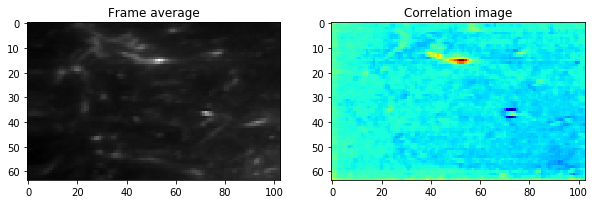

In [73]:
# sanity check the image
avg_img = np.mean(images,axis=0)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(avg_img, cmap='gray'), plt.title('Frame average')
plt.subplot(1,2,2)
plt.imshow(Cn, cmap='jet'), plt.title('Correlation image')

### Run single CNMF on full FoV, without patches

In [74]:
# Configure CNMF and fit to the data
cnmf_single = cnmf.CNMF(n_processes, k=params['K'], gSig=params['gSig'], merge_thresh=params['merge_thresh'], 
                p=params['p'], dview=dview, Ain=None, gnb=params['gnb'], rf=params['rf'],
                memory_fact=1, method_init=params['init_method'], alpha_snmf=params['alpha_snmf'],
                method_deconvolution=params['method_deconvolution'])
cnmf_single = cnmf_single.fit(images)

(10457, 64, 103)
using 8 processes
using 4000 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(5228, 51)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
memmaping
Updating Spatial Components using lasso lars
thresholding components
eliminating 2 empty spatial components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 2]
Filling
--- 17.65414834022522 seconds ---
Removing tempfiles created
update temporal ...
deconvolution ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 2]
Transposing
entering the deconvolution 
1 out of total 18 temporal components updated
4 out of total 18 temporal components updated
7 out of total 18 temporal components updated
9 out of total 18 temporal components 

/home/schoenfeld/.conda/envs/caiman/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 5000
Start product
Processed:[0, 2]
Filling
--- 18.772069215774536 seconds ---
Removing tempfiles created
update temporal ...
Generating residuals
parallel dot product block size: 5000
Start product
Processed:[0, 2]
Transposing
entering the deconvolution 
1 out of total 18 temporal components updated
4 out of total 18 temporal components updated
7 out of total 18 temporal components updated
10 out of total 18 temporal components updated
12 out of total 18 temporal components updated
14 out of total 18 temporal components updated
16 out of total 18 temporal components updated
17 out of total 18 temporal components updated
18 out of total 18 temporal components updated
1 out of total 18 temporal components updated
4 out of total 18 temporal components updated
7 out of total 18 temporal components updated
10 out of total 18 temporal components updated
12 out 

In [75]:
# Unravel results
A, C, b, f, YrA, sn = cnmf_single.A, cnmf_single.C, cnmf_single.b, cnmf_single.f, cnmf_single.YrA, cnmf_single.sn
# A   ... n_pixel x n_components sparse matrix (component locations)
# C   ... n_component x t np.array (fitted signal)
# b   ... ? np.array
# f   ... ? np.array (b / f related to global background components)
# YrA ... n_component x t np.array (residual)
# sn  ... n_pixel np.array (SNR?)

print('Detected components: %1.0f' % (C.shape[0]))

Detected components: 18


Evaluate components (discard low quality components).

In [76]:
r_values_min = .65         # threshold on space consistency
fitness_min = -100        # threshold on time variability
fitness_delta_min = -100  # threshold on time variability (if nonsparse activity)
Npeaks = 100
thresh_C = 0.3
Athresh = 0.1

traces = C + YrA
idx_comps, idx_comps_bad, fitness_raw, fitness_delta, r_values = estimate_q(traces, Y, A, C, b, f, final_frate=params['final_rate'], 
                                      Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min, 
                                      fitness_delta_min=fitness_delta_min, thresh_C=thresh_C, Athresh=Athresh,
                                      return_all=True)
print('Good / bad components: %1.0f / %1.0f' % (len(idx_comps), len(idx_comps_bad)))

tB:-3.0,tA:11.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(14, 18)
Computing event exceptionality
Evaluating spatial footprint
components evaluated:0
Good / bad components: 3 / 15


/home/schoenfeld/caiman/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


Text(0.5,1,'Contour plots of rejected components')

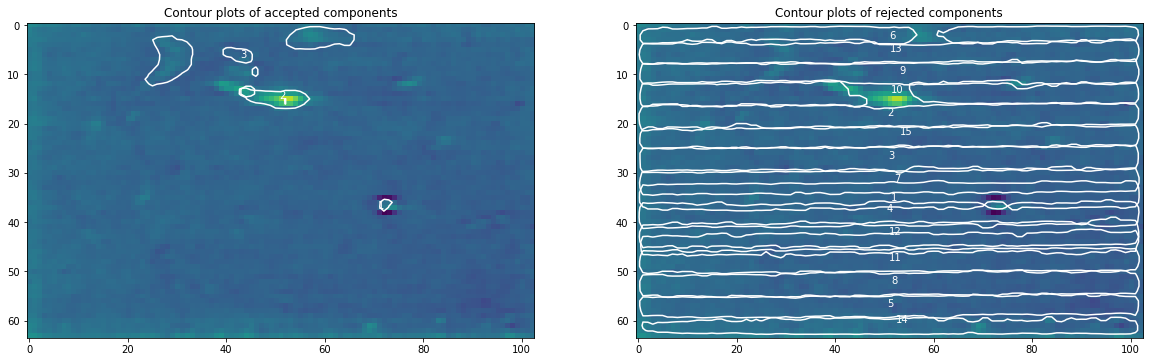

In [77]:
# Plot good and bad components
plt.figure(figsize=(20,30));
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(A[:,idx_comps], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(A[:,idx_comps_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

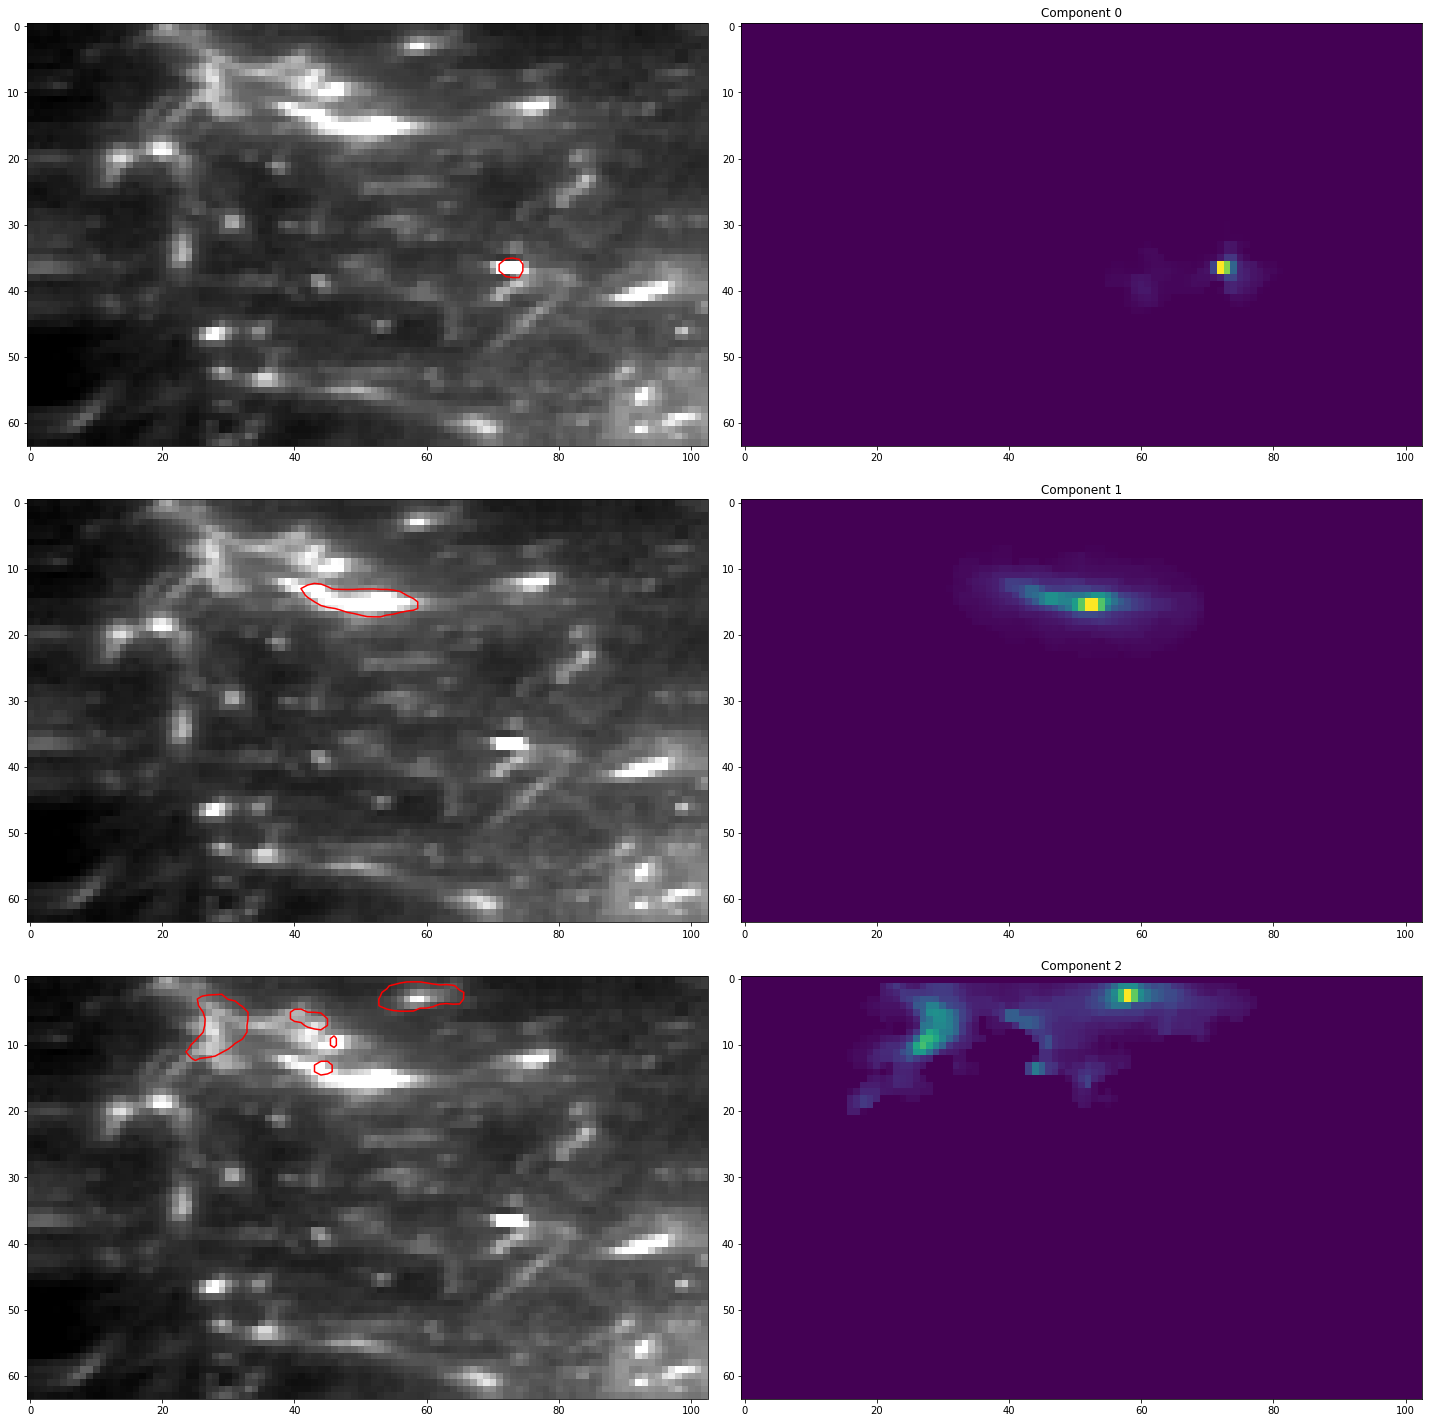

In [78]:
# Plot good components on background image and as component map
A_dense = A.todense()
counter = 1
plt.figure(figsize=(20,20));
for i_comp in range(len(idx_comps)):
    plt.subplot(len(idx_comps),2,counter)
    counter += 1
    dummy = cm.utils.visualization.plot_contours(A[:,idx_comps[i_comp]], avg_img, cmap='gray', 
                                                 colors='r', display_numbers=False)
    component_img = np.array(np.reshape(A_dense[:,idx_comps[i_comp]], dims, order='F'))
    plt.subplot(len(idx_comps),2,counter)
    counter += 1
    plt.imshow(component_img), plt.title('Component %1.0f' % (i_comp))
    
    if i_comp == 0:
        component_matrix = component_img
    else:
        component_matrix = np.dstack((component_matrix, component_img))
plt.tight_layout()

### Save and view results

In [79]:
# saving
npz_name = os.path.join(data_folder, '%s_%s_Join_%s_results_CNMF.npz' % (date_folder, session_folder, group_id))
np.savez(npz_name, Cn=Cn, A=A.todense(), C=C, b=b, f=f, YrA=YrA, sn=sn, 
         d1=d1, d2=d2, idx_components=idx_comps, idx_components_bad=idx_comps_bad)

Interactive viewer for traces of accepted and rejected components
**Currently does not work remotely!**

In [80]:
# accepted components
if len(idx_comps) > 0:
    nb_view_patches(Yr, A.tocsc()[:, idx_comps], C[idx_comps], 
                    b, f, dims[0], dims[1], YrA=YrA[idx_comps], image_neurons = Cn,
                    denoised_color = 'red');
else:
    print("No accepted components!")

### Calculate DFF and plot traces
The CaImAn function `detrend_df_f` uses a sliding window percentile filter to determine the baseline and compute DFF. 

In [81]:
F_dff = cnmf_utils.detrend_df_f(A, b, C, f, YrA = YrA, quantileMin=8, frames_window=100)
# select good components
F_dff = F_dff[idx_comps,:]

t = np.arange(0, F_dff.shape[-1]) / params['final_rate']

For plotting we use the Bokeh interactive visualization library, which offers a number of nice features for plotting and interacting with plots.

In [82]:
# This has to be in a separate cell, otherwise it wont work.
from bokeh import resources
output_notebook(resources=resources.INLINE)

Loading BokehJS ...

Define some functions for plotting.

In [83]:
def getHover():
    """Define and return hover tool for a plot"""
    # Define hover tool
    hover = HoverTool()
    hover.tooltips = [
        ("index", "$index"),
        ("(x,y)", "($x, $y)"),
    ]
    return hover

In [84]:
def plotTimeseries(p, t, y, legend=None, stack=True, xlabel='', ylabel='', output_backend='canvas'):
    """
    Plot a timeseries in Figure p using the Bokeh library
    
    Input arguments:
    p ... Bokeh figure
    t ... 1d time axis vector (numpy array)
    y ... 2d data numpy array (number of traces x time)
    legend ... list of items to be used as figure legend
    stack ... whether to stack traces or nor (True / False)
    xlabel ... label for x-axis
    ylabel ... label for y-axis
    output_backend ... 'canvas' or 'svg'
    """
    
    colors_list = ['red', 'green', 'blue', 'yellow', 'cyan', 'orange', 'magenta', 'black', 'gray']
    p.add_tools(CrosshairTool(), getHover())
    
    offset = 0
    for i in range(y.shape[0]):
        if len(colors_list) < i+1:
            colors_list = colors_list + colors_list
        
        plot_trace = y[i, :]
        if stack:
            plot_trace = plot_trace - min(plot_trace) + offset
            offset = max(plot_trace)
        
        p.line(t, plot_trace, line_width=2, legend=legend[i], color=colors_list[i])
        
#     p.legend.location = (0,-30)
    p.legend.click_policy="hide"
    
    # format plot
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    
    p.x_range = Range1d(np.min(t), np.max(t))
    
    p.background_fill_color = None
    p.border_fill_color = None
    
    p.output_backend = output_backend

    show(p)
    
    return p

The next cell plots the figure. The function `plotTimeseries` can plot traces on top of each other (`stack=False`) or stacked (`stack=True`). The interactive toolbar on the right of the figures allows panning, zooming, saving etc. One can also hide traces by clicking the corresponding legend item. To save the figure, click the disk icon in the plotting toolbar. With the default `output_backend` ('canvas'), a png file will be saved. To save to svg format, change `output_backend` to 'svg'.

In [85]:
p = Figure(plot_width=800, plot_height=300, 
           title=('%s %s CNMF Results' % (date_folder, session_folder)))    
legend_text = ['Component %1d' % (x) for x in range(len(idx_comps))]
# this is the call to the plotting function (change args. as required)
plotTimeseries(p, t, F_dff, 
               legend=legend_text, 
               stack=True, 
               xlabel='Time [s]', ylabel='DFF',
               output_backend='canvas'
              )

Figure(id='c4c942e6-9944-47a8-91d2-a06e3da5c83a', ...)

### Split up by trials and save as .mat

In [54]:
# split up F_dff by trials
# Todo: correct source_frames: key
source_files = meta['source_file']
source_frames = np.array(meta['source_frames'])

In [55]:
# check if our numbers match
if not (np.sum(source_frames)-len(bad_frames)) == F_dff.shape[-1]:
    raise Exception('Sum of source frames minus number of bad frames must be equal to number of timepoints.')

In [56]:
results_dff = dict()
removed_frames = dict()
bad_frames_removed = []
start_frame = 0
for ix, trial_file in enumerate(source_files):
    trial_indices = list(range(start_frame, source_frames[ix] + start_frame))
#     print(trial_file)
#     print('Start / stop: %1.0f / %1.0f' % (trial_indices[0], trial_indices[-1]))
    
    # check if trial contains bad frames (that have not been removed yet)
    bad = [x for x in bad_frames if x in trial_indices and x not in bad_frames_removed]
    
    # remove indices of bad frames
    if len(bad) > 0:
#         print('Found %1.0f bad frames' % (len(bad)))
        del trial_indices[-len(bad):]
#         print('Removed frames (relative to trial start):')
        for i_bad in bad:
            bad_frames_removed.append(i_bad)
        removed_frames_trial = [x-trial_indices[0] for x in bad]
    else:
        removed_frames_trial = []
    
#     print('Start / stop: %1.0f / %1.0f\n' % (trial_indices[0], trial_indices[-1]))
    
    # create a valid Matlab variable / field name
    field_name = str('x' + source_files[ix]).replace('.tif','').replace('-','_')
    results_dff[field_name] = F_dff[:,trial_indices]
    removed_frames[field_name] = removed_frames_trial
    
    start_frame = trial_indices[-1] + 1

In [57]:
# prepare the dictionary for saving as mat file
# the field names will be the variable names in Matlab
mdict={'trials': [str(x) for x in source_files], 
       'dff_trial': results_dff, 
       'removed_frames': removed_frames,
       'mean_image': avg_img,
       'spatial_components': component_matrix
      }

In [58]:
# save the .mat file
matfile_name = os.path.join(data_folder, '%s_%s_Join_%s_results_CNMF.mat' % (date_folder, session_folder, group_id))
savemat(os.path.join(data_folder, matfile_name), mdict=mdict)